In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.datasets import make_circles
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
# Gerar dataset make_circles
X, y = make_circles(n_samples=500, noise=0.1, factor=0.5, random_state=42)

df = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
df['target'] = y
df.head()

,feature_1,feature_2,target
0,-0.469186,0.247915,1
1,-0.067487,1.006769,0
2,-0.443065,0.027383,1
3,-0.611725,-0.631407,0
4,-0.789013,0.684519,0


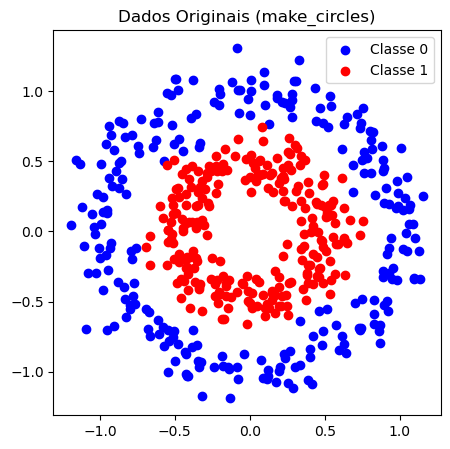

In [3]:
# Visualização inicial
plt.figure(figsize=(5, 5))
plt.scatter(X[y == 0, 0], X[y == 0, 1], color='blue', label='Classe 0')
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='red', label='Classe 1')
plt.title('Dados Originais (make_circles)')
plt.legend()
plt.show()

In [4]:
# Separar treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Pré-processamento (fit no treino, transform em ambos)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
# Treinar e avaliar SVM com diferentes kernels
kernels = [
    ('linear', {}),
    ('poly', {'degree': 2}),
    ('poly', {'degree': 3}),
    ('rbf', {'gamma': 'scale'})
]


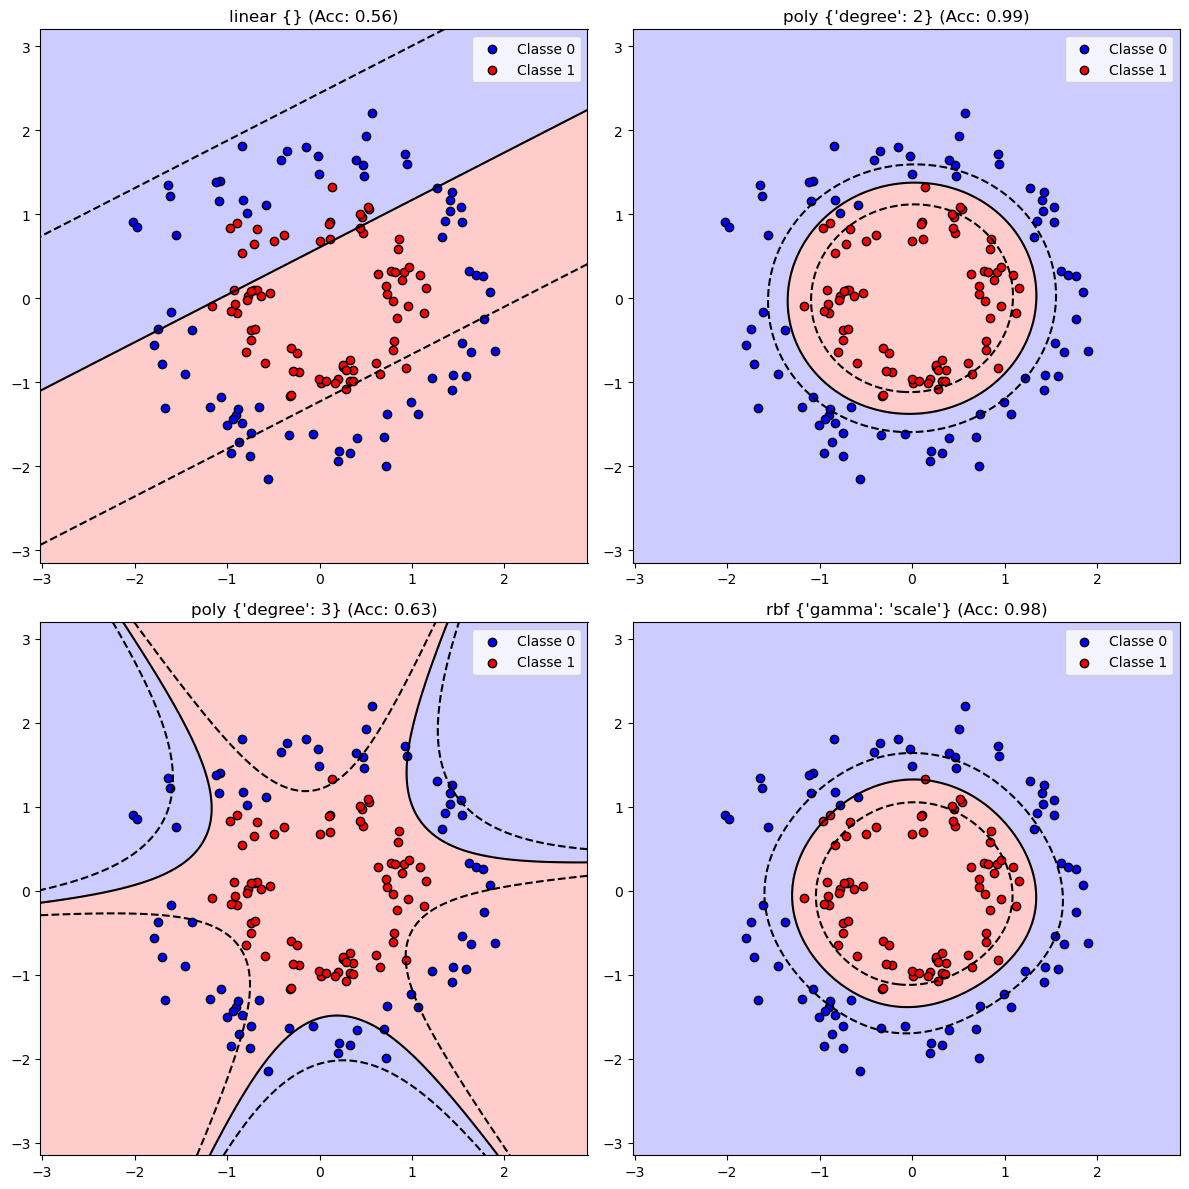

In [7]:
# Grid com regiões de decisão
fig_decision, axs_decision = plt.subplots(2, 2, figsize=(12, 12))

for idx, (kernel_name, params) in enumerate(kernels):
    clf = SVC(kernel=kernel_name, C=1.0, **params)
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    
    # Região de decisão
    xx, yy = np.meshgrid(np.linspace(X_test_scaled[:, 0].min() - 1, X_test_scaled[:, 0].max() + 1, 500),
                         np.linspace(X_test_scaled[:, 1].min() - 1, X_test_scaled[:, 1].max() + 1, 500))
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ax = axs_decision[idx // 2, idx % 2]
    ax.contourf(xx, yy, Z > 0, alpha=0.2, levels=[-1, 0, 1], colors=['blue', 'red'])
    ax.contour(xx, yy, Z, levels=[-1, 0, 1], linestyles=['--', '-', '--'], colors='k')
    ax.scatter(X_test_scaled[y_test == 0, 0], X_test_scaled[y_test == 0, 1], color='blue', edgecolor='k', label='Classe 0')
    ax.scatter(X_test_scaled[y_test == 1, 0], X_test_scaled[y_test == 1, 1], color='red', edgecolor='k', label='Classe 1')
    ax.set_title(f"{kernel_name} {params} (Acc: {acc:.2f})")
    ax.legend()

plt.tight_layout()
plt.show()

In [8]:
for idx, (kernel_name, params) in enumerate(kernels):
    clf = SVC(kernel=kernel_name, C=1.0, **params)
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n==== Kernel: {kernel_name} {params} ====")
    print(f"Acurácia no teste: {acc:.3f}")
    print(classification_report(y_test, y_pred))


==== Kernel: linear {} ====
Acurácia no teste: 0.560
              precision    recall  f1-score   support

           0       0.60      0.35      0.44        75
           1       0.54      0.77      0.64        75

    accuracy                           0.56       150
   macro avg       0.57      0.56      0.54       150
weighted avg       0.57      0.56      0.54       150


==== Kernel: poly {'degree': 2} ====
Acurácia no teste: 0.987
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        75
           1       0.97      1.00      0.99        75

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150


==== Kernel: poly {'degree': 3} ====
Acurácia no teste: 0.633
              precision    recall  f1-score   support

           0       1.00      0.27      0.42        75
           1       0.58      1.00      0.73        75

  

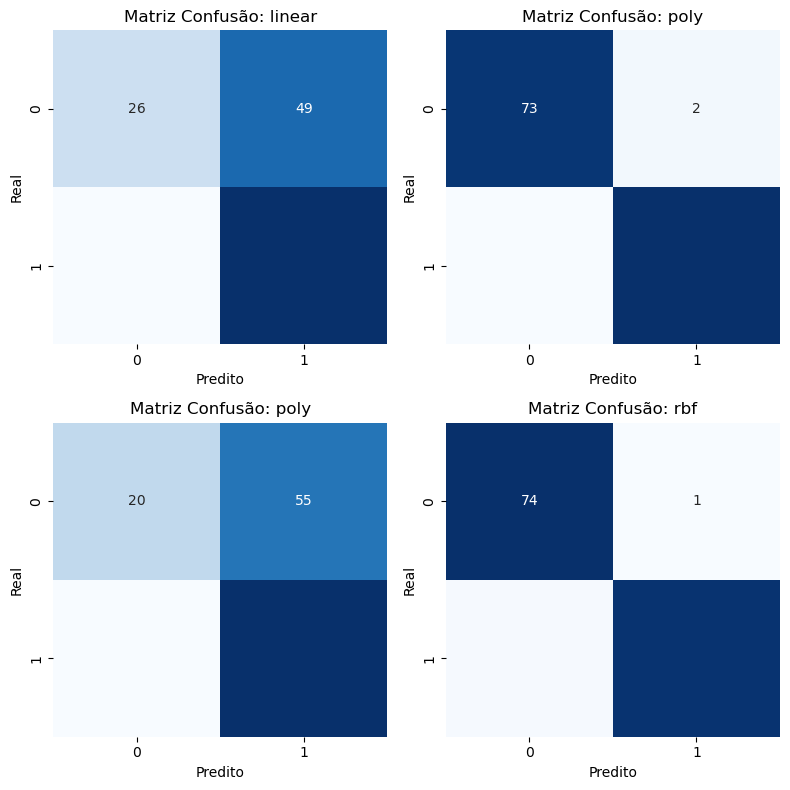

In [9]:
# Grid com matrizes de confusão
fig_cm, axs_cm = plt.subplots(2, 2, figsize=(8, 8))

for idx, (kernel_name, params) in enumerate(kernels):
    clf = SVC(kernel=kernel_name, C=1.0, **params)
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # print(f"\n==== Kernel: {kernel_name} {params} ====")
    # print(f"Acurácia no teste: {acc:.3f}")
    # print(classification_report(y_test, y_pred))
    
    ax = axs_cm[idx // 2, idx % 2]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(f"Matriz Confusão: {kernel_name}")
    ax.set_xlabel('Predito')
    ax.set_ylabel('Real')

plt.tight_layout()
plt.show()

In [10]:
from sklearn.model_selection import GridSearchCV

# Dicionário para guardar os melhores estimadores
best_models = {}

# Parâmetros a testar por kernel
param_grids = {
    'linear': {'C': [0.01, 0.1, 1, 10]},
    'poly': {'C': [0.01, 0.1, 1, 10], 'degree': [2, 3, 4]},
    'rbf': {'C': [0.01, 0.1, 1, 10], 'gamma': [0.01, 0.1, 1, 'scale']}
}

for kernel in param_grids:
    print(f"\n🔍 Grid Search para kernel: {kernel}")
    svc = SVC(kernel=kernel)
    grid = GridSearchCV(svc, param_grids[kernel], cv=5)
    grid.fit(X_train_scaled, y_train)
    best_models[kernel] = grid.best_estimator_
    print("Melhores parâmetros:", grid.best_params_)
    print("Acurácia validação cruzada:", grid.best_score_)



🔍 Grid Search para kernel: linear
Melhores parâmetros: {'C': 0.01}
Acurácia validação cruzada: 0.5314285714285714

🔍 Grid Search para kernel: poly
Melhores parâmetros: {'C': 10, 'degree': 2}
Acurácia validação cruzada: 0.9885714285714287

🔍 Grid Search para kernel: rbf
Melhores parâmetros: {'C': 0.1, 'gamma': 1}
Acurácia validação cruzada: 0.9857142857142858


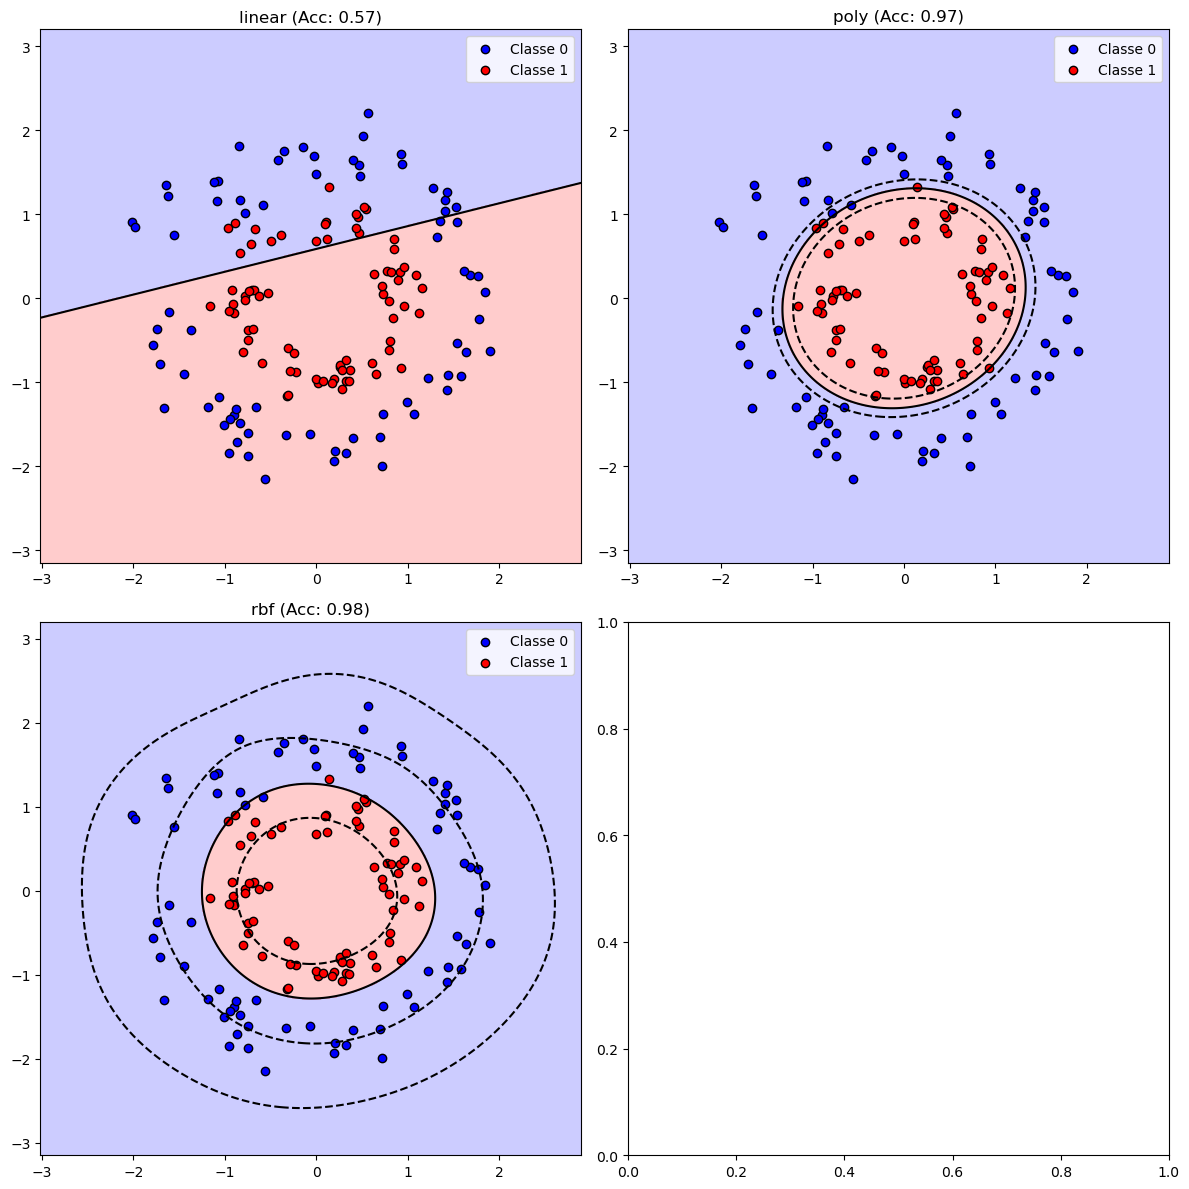

In [11]:
# Grid de visualizações
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

for idx, (kernel, model) in enumerate(best_models.items()):
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    
    # Região de decisão
    xx, yy = np.meshgrid(np.linspace(X_test_scaled[:, 0].min() - 1, X_test_scaled[:, 0].max() + 1, 500),
                         np.linspace(X_test_scaled[:, 1].min() - 1, X_test_scaled[:, 1].max() + 1, 500))
    Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ax = axs[idx // 2, idx % 2]
    ax.contourf(xx, yy, Z > 0, alpha=0.2, levels=[-1, 0, 1], colors=['blue', 'red'])
    ax.contour(xx, yy, Z, levels=[-1, 0, 1], linestyles=['--', '-', '--'], colors='k')
    ax.scatter(X_test_scaled[y_test == 0, 0], X_test_scaled[y_test == 0, 1], color='blue', edgecolor='k', label='Classe 0')
    ax.scatter(X_test_scaled[y_test == 1, 0], X_test_scaled[y_test == 1, 1], color='red', edgecolor='k', label='Classe 1')
    ax.set_title(f"{kernel} (Acc: {acc:.2f})")
    ax.legend()

plt.tight_layout()
plt.show()
